# Laboratory 5: Convolutional Neural Networks

In this laboratory session we will train some CNNs to recognize color images in the [CIFAR-10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

## Part 1: Initial Setup and Data Exploration

We begin with some standard imports, as usual.

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Standard Pytorch imports (note the aliases).
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import warnings

# Ignora tutti gli avvisi
warnings.filterwarnings("ignore") # in questo modo in output non verranno mostrati dei warning di poco conto nelle prossime celle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cpu


### Exercise 1.1: Dataset and Dataloader Preparation

The `torchvision` library provides a class (with the same interface as MNIST) for the CIFAR-10 dataset. As with MNIST, it will automatically download and prepare the dataset for use. Use the CIFAR10 class to load the training, validation (use 2000 images), and test splits.

**Note**: Don't forget to *transform* the images in the datasets to convert them to tensors and standardize them!

**Hint**: Feel free to copy-and-paste liberally from the notebook I published for the capsule lecture. **BUT**, make sure you know what you are doing, and be aware that *some* of the code will have to be adapted for use with the CIFAR10 dataset.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split, Subset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_val_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


### Exercise 1.2: Dataloaders
Set up dataloaders for **all** of the datasets -- even though the validation set is small! Test out the datasets defined above and the dataloaders to make sure you understand the dataset format. Visualize some of the images to get a feel for the type of images and classes in CIFAR-10.

In [4]:
# Setup dataloaders for all three datasets. Use the largest batch size possible.
batch_size = 256

train_size = len(train_val_dataset) - 2000
val_size = 2000
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(f"Batch shape of images: {images.shape}")  
print(f"Batch shape of labels: {labels.shape}")  
print(f"Image data type: {images.dtype}")  
print(f"Labels data type: {labels.dtype}")  

Batch shape of images: torch.Size([256, 3, 32, 32])
Batch shape of labels: torch.Size([256])
Image data type: torch.float32
Labels data type: torch.int64


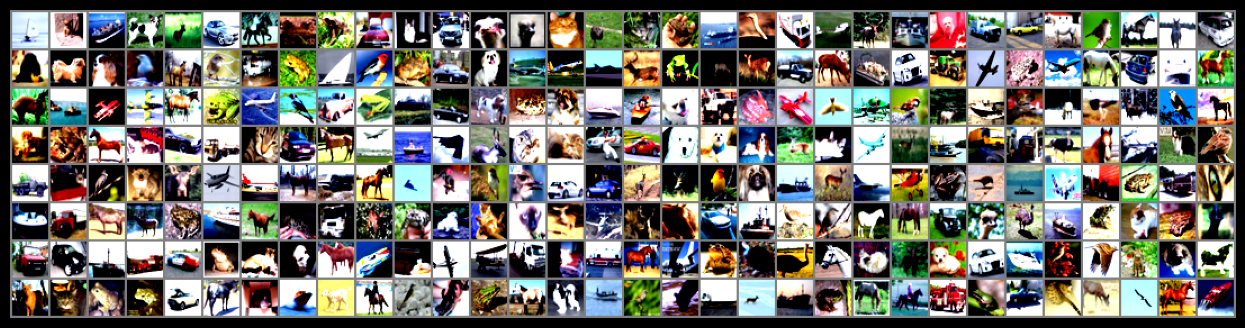

In [5]:
# Funzione per denormalizzare le immagini
def imshow(img):
    img = img / 2 + 0.5  
    img = np.clip(img, 0, 1)  
    npimg = img.numpy()
    plt.figure(figsize=(20, 4))  
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  
    plt.show()
    
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images, nrow=32))

## Part 2: Establishing a stable baseline

In this part of the laboratory we will establish a simple baseline as a starting point.

### Exercise 2.1: An MLP Baseline

Define a simple Multilayer Perceptron to classify the CIFAR-10 images. Define it as a class inheriting from torch.nn.Module. Don't make it too complex or too deep. We're just looking for a starting point. A *baseline*.

In [6]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()  
        self.fc1 = nn.Linear(3 * 32 * 32, 512)  
        self.fc2 = nn.Linear(512, 256)  
        self.fc3 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLP()

print(model)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


### Exercise 2.2: Train and Evaluate your MLP Baseline

Train the model for a few (say, 20) epochs. Again, feel free to use my training code from the Capsule Lecture (or roll your own, mine is very basic). Make sure you plot training curves and report accuracy on the test set.

In [7]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
        xs = xs.to(device)
        ys = ys.to(device)
        opt.zero_grad()
        logits = model(xs)
        loss = F.cross_entropy(logits, ys)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return np.mean(losses)


# Funzione di valutazione
def evaluate_model(model, dl, device='cpu'):
    model.eval()
    predictions = []
    gts = []
    for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
        xs = xs.to(device)
        ys = ys.to(device)
        preds = torch.argmax(model(xs), dim=1)
        gts.append(ys.detach().cpu().numpy())
        predictions.append(preds.detach().cpu().numpy())
        
    # Return accuracy score and classification report.
    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

# Funzione per tracciare le curve di addestramento e validazione
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')
    plt.show()


Training epoch 0: 100%|██████████| 188/188 [00:20<00:00,  9.19it/s]


Epoch [1/20], Train Loss: 2.0946, Validation Accuracy: 0.3205


Training epoch 1: 100%|██████████| 188/188 [00:19<00:00,  9.51it/s]


Epoch [2/20], Train Loss: 1.8577, Validation Accuracy: 0.3600


Training epoch 2: 100%|██████████| 188/188 [00:20<00:00,  9.20it/s]


Epoch [3/20], Train Loss: 1.7432, Validation Accuracy: 0.3850


Training epoch 3: 100%|██████████| 188/188 [00:20<00:00,  9.35it/s]


Epoch [4/20], Train Loss: 1.6699, Validation Accuracy: 0.4155


Training epoch 4: 100%|██████████| 188/188 [00:21<00:00,  8.64it/s]


Epoch [5/20], Train Loss: 1.6155, Validation Accuracy: 0.4335


Training epoch 5: 100%|██████████| 188/188 [00:22<00:00,  8.49it/s]


Epoch [6/20], Train Loss: 1.5713, Validation Accuracy: 0.4435


Training epoch 6: 100%|██████████| 188/188 [00:21<00:00,  8.59it/s]


Epoch [7/20], Train Loss: 1.5351, Validation Accuracy: 0.4520


Training epoch 7: 100%|██████████| 188/188 [00:21<00:00,  8.61it/s]


Epoch [8/20], Train Loss: 1.5010, Validation Accuracy: 0.4645


Training epoch 8: 100%|██████████| 188/188 [00:22<00:00,  8.39it/s]


Epoch [9/20], Train Loss: 1.4703, Validation Accuracy: 0.4700


Training epoch 9: 100%|██████████| 188/188 [00:21<00:00,  8.83it/s]


Epoch [10/20], Train Loss: 1.4428, Validation Accuracy: 0.4815


Training epoch 10: 100%|██████████| 188/188 [00:25<00:00,  7.30it/s]


Epoch [11/20], Train Loss: 1.4146, Validation Accuracy: 0.4805


Training epoch 11: 100%|██████████| 188/188 [00:23<00:00,  8.01it/s]


Epoch [12/20], Train Loss: 1.3896, Validation Accuracy: 0.4850


Training epoch 12: 100%|██████████| 188/188 [00:19<00:00,  9.58it/s]


Epoch [13/20], Train Loss: 1.3644, Validation Accuracy: 0.4875


Training epoch 13: 100%|██████████| 188/188 [00:20<00:00,  9.38it/s]


Epoch [14/20], Train Loss: 1.3408, Validation Accuracy: 0.4920


Training epoch 14: 100%|██████████| 188/188 [00:19<00:00,  9.61it/s]


Epoch [15/20], Train Loss: 1.3177, Validation Accuracy: 0.4905


Training epoch 15: 100%|██████████| 188/188 [00:19<00:00,  9.65it/s]


Epoch [16/20], Train Loss: 1.2958, Validation Accuracy: 0.5005


Training epoch 16: 100%|██████████| 188/188 [00:19<00:00,  9.77it/s]


Epoch [17/20], Train Loss: 1.2734, Validation Accuracy: 0.4955


Training epoch 17: 100%|██████████| 188/188 [00:19<00:00,  9.57it/s]


Epoch [18/20], Train Loss: 1.2525, Validation Accuracy: 0.4995


Training epoch 18: 100%|██████████| 188/188 [00:19<00:00,  9.60it/s]


Epoch [19/20], Train Loss: 1.2326, Validation Accuracy: 0.5020


Training epoch 19: 100%|██████████| 188/188 [00:18<00:00, 10.01it/s]


Epoch [20/20], Train Loss: 1.2110, Validation Accuracy: 0.5055


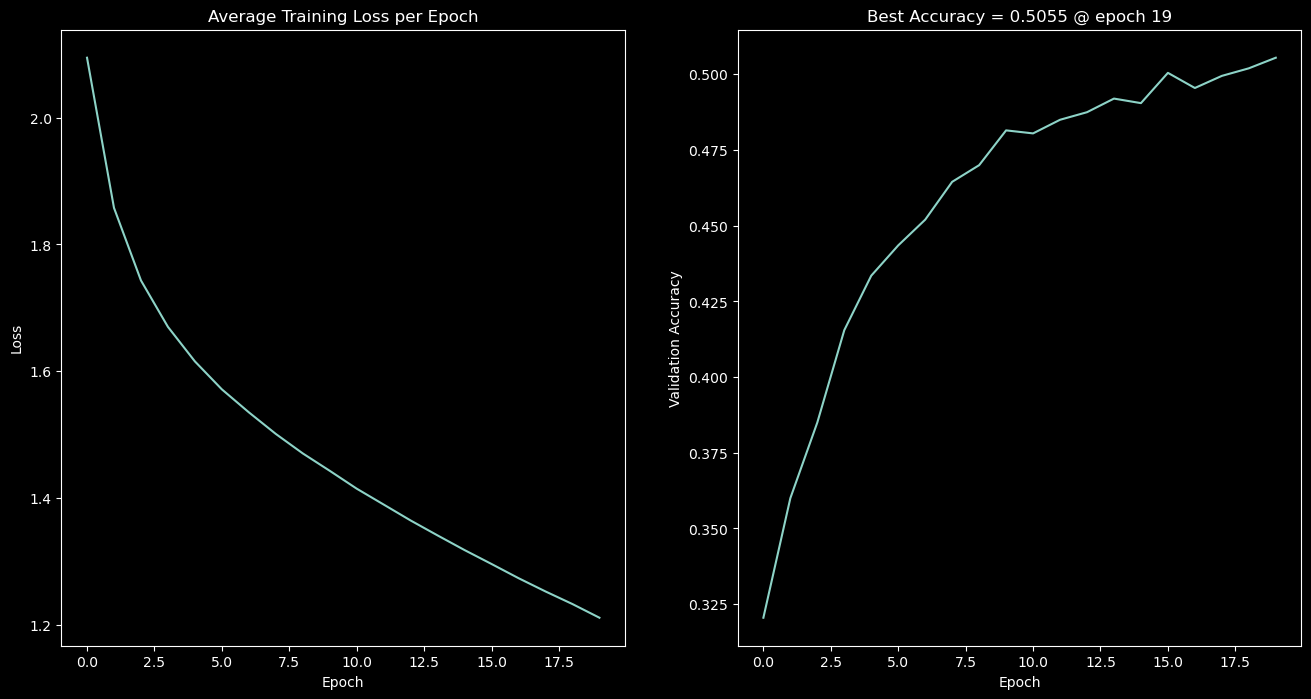

Test Accuracy: 0.5264
              precision    recall  f1-score   support

           0      0.627     0.574     0.599      1000
           1      0.638     0.649     0.644      1000
           2      0.433     0.392     0.412      1000
           3      0.381     0.354     0.367      1000
           4      0.469     0.395     0.429      1000
           5      0.440     0.414     0.427      1000
           6      0.505     0.622     0.557      1000
           7      0.552     0.610     0.580      1000
           8      0.605     0.682     0.641      1000
           9      0.580     0.572     0.576      1000

    accuracy                          0.526     10000
   macro avg      0.523     0.526     0.523     10000
weighted avg      0.523     0.526     0.523     10000



In [8]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 20
losses_and_accs = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, epoch=epoch, device=device)
    val_accuracy, _ = evaluate_model(model, val_loader, device=device)
    losses_and_accs.append((train_loss, val_accuracy))
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

plot_validation_curves(losses_and_accs)

test_accuracy, test_report = evaluate_model(model, test_loader, device=device)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(test_report)

## Part 3: A CNN for CIFAR-10 Classification

OK, we have a (simple) MLP baseline for comparison. Let's implement a simple CNN to classify CIFAR-10 images and see if we can beat the MLP.

### Exercise 3.1: Defining the CNN

Define a simple CNN model with a few convolutional and maxppooling layers -- not too many, since CIFAR-10 images are only 32x32 pixels! Use two fully-connected layers after the last convolution and before the logit outputs. Test out the model by passing a *single* image through it to make sure it's working.

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Primo strato convoluzionale
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Strato di max pooling
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Secondo strato convoluzionale
        self.fc1 = nn.Linear(64 * 8 * 8, 256)  # Primo strato completamente connesso
        self.fc2 = nn.Linear(256, 128)  # Secondo strato completamente connesso
        self.fc3 = nn.Linear(128, 10)  # Strato di output con 10 classi
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Applica conv1, ReLU e max pooling
        x = self.pool(F.relu(self.conv2(x)))  # Applica conv2, ReLU e max pooling
        x = x.view(-1, 64 * 8 * 8)  
        x = F.relu(self.fc1(x))  # Applica fc1 e ReLU
        x = F.relu(self.fc2(x))  # Applica fc2 e ReLU
        x = self.fc3(x)  # Applica fc3 (output logit)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)


In [10]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

output = model(images[0].unsqueeze(0))
print(output)

print(model)

tensor([[ 0.0743,  0.0304, -0.0558,  0.0046, -0.0202,  0.0496, -0.0625, -0.0468,
         -0.0146,  0.0134]], grad_fn=<AddmmBackward0>)
CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


### Exercise 3.2: Training and Evaluating your CNN

Train the CNN using similar hyperparameters to what you used for the MLP above (epochs, learning rate). Evaluate the model in the same way as before.

Training epoch 0: 100%|██████████| 188/188 [01:07<00:00,  2.80it/s]


Epoch [1/20], Train Loss: 2.2861, Validation Accuracy: 0.1875


Training epoch 1: 100%|██████████| 188/188 [01:12<00:00,  2.60it/s]


Epoch [2/20], Train Loss: 2.1791, Validation Accuracy: 0.2965


Training epoch 2: 100%|██████████| 188/188 [01:01<00:00,  3.07it/s]


Epoch [3/20], Train Loss: 1.9637, Validation Accuracy: 0.3400


Training epoch 3: 100%|██████████| 188/188 [01:01<00:00,  3.07it/s]


Epoch [4/20], Train Loss: 1.8085, Validation Accuracy: 0.3645


Training epoch 4: 100%|██████████| 188/188 [01:05<00:00,  2.86it/s]


Epoch [5/20], Train Loss: 1.6995, Validation Accuracy: 0.3945


Training epoch 5: 100%|██████████| 188/188 [01:02<00:00,  2.99it/s]


Epoch [6/20], Train Loss: 1.5942, Validation Accuracy: 0.4455


Training epoch 6: 100%|██████████| 188/188 [01:01<00:00,  3.04it/s]


Epoch [7/20], Train Loss: 1.4966, Validation Accuracy: 0.4875


Training epoch 7: 100%|██████████| 188/188 [01:03<00:00,  2.95it/s]


Epoch [8/20], Train Loss: 1.4232, Validation Accuracy: 0.4915


Training epoch 8: 100%|██████████| 188/188 [01:05<00:00,  2.87it/s]


Epoch [9/20], Train Loss: 1.3729, Validation Accuracy: 0.5135


Training epoch 9: 100%|██████████| 188/188 [01:05<00:00,  2.87it/s]


Epoch [10/20], Train Loss: 1.3314, Validation Accuracy: 0.5255


Training epoch 10: 100%|██████████| 188/188 [01:04<00:00,  2.89it/s]


Epoch [11/20], Train Loss: 1.2936, Validation Accuracy: 0.5520


Training epoch 11: 100%|██████████| 188/188 [01:03<00:00,  2.95it/s]


Epoch [12/20], Train Loss: 1.2651, Validation Accuracy: 0.5645


Training epoch 12: 100%|██████████| 188/188 [01:03<00:00,  2.96it/s]


Epoch [13/20], Train Loss: 1.2306, Validation Accuracy: 0.5580


Training epoch 13: 100%|██████████| 188/188 [01:03<00:00,  2.94it/s]


Epoch [14/20], Train Loss: 1.2008, Validation Accuracy: 0.5700


Training epoch 14: 100%|██████████| 188/188 [00:59<00:00,  3.16it/s]


Epoch [15/20], Train Loss: 1.1763, Validation Accuracy: 0.5650


Training epoch 15: 100%|██████████| 188/188 [01:03<00:00,  2.94it/s]


Epoch [16/20], Train Loss: 1.1503, Validation Accuracy: 0.5890


Training epoch 16: 100%|██████████| 188/188 [01:02<00:00,  3.00it/s]


Epoch [17/20], Train Loss: 1.1243, Validation Accuracy: 0.5905


Training epoch 17: 100%|██████████| 188/188 [00:58<00:00,  3.22it/s]


Epoch [18/20], Train Loss: 1.0969, Validation Accuracy: 0.6040


Training epoch 18: 100%|██████████| 188/188 [00:58<00:00,  3.21it/s]


Epoch [19/20], Train Loss: 1.0728, Validation Accuracy: 0.6060


Training epoch 19: 100%|██████████| 188/188 [01:01<00:00,  3.07it/s]


Epoch [20/20], Train Loss: 1.0542, Validation Accuracy: 0.6180


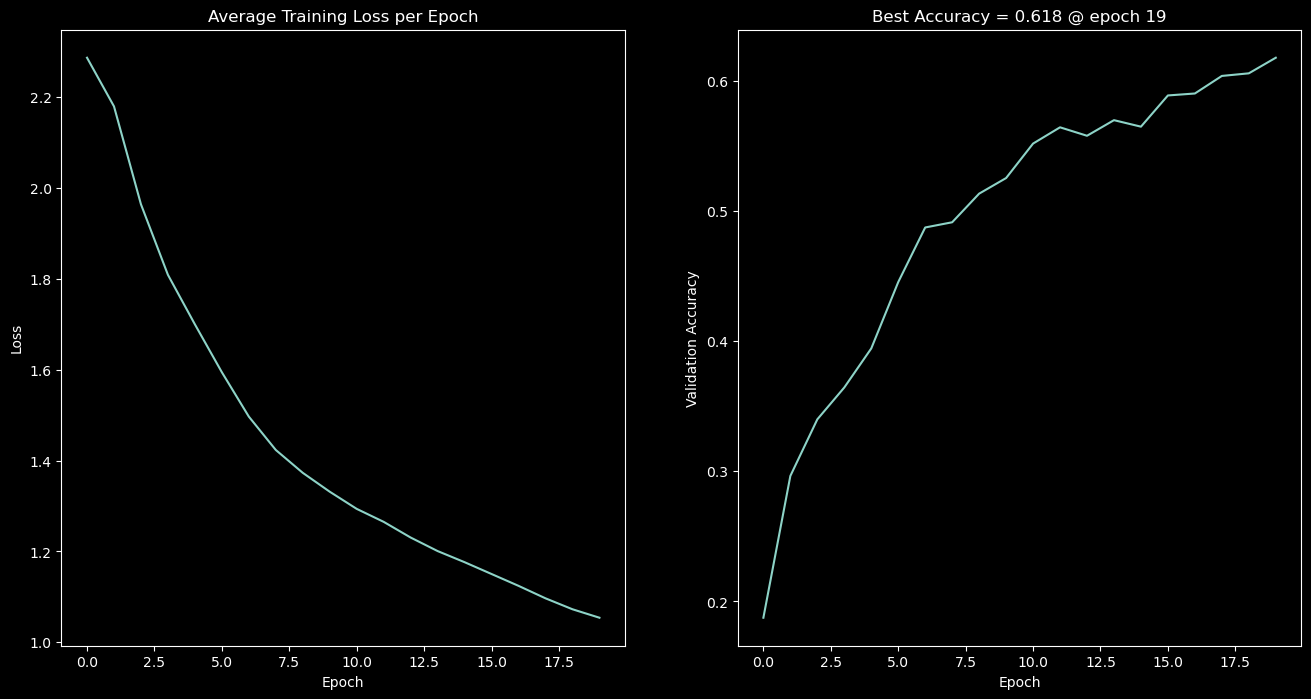

Test Accuracy: 0.6189
              precision    recall  f1-score   support

           0      0.674     0.685     0.680      1000
           1      0.757     0.721     0.739      1000
           2      0.448     0.519     0.481      1000
           3      0.501     0.346     0.409      1000
           4      0.530     0.505     0.517      1000
           5      0.592     0.456     0.515      1000
           6      0.603     0.790     0.684      1000
           7      0.695     0.693     0.694      1000
           8      0.714     0.770     0.741      1000
           9      0.655     0.704     0.679      1000

    accuracy                          0.619     10000
   macro avg      0.617     0.619     0.614     10000
weighted avg      0.617     0.619     0.614     10000



In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 20
losses_and_accs = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, epoch=epoch, device=device)
    val_accuracy, _ = evaluate_model(model, val_loader, device=device)
    losses_and_accs.append((train_loss, val_accuracy))
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

plot_validation_curves(losses_and_accs)

test_accuracy, test_report = evaluate_model(model, test_loader, device=device)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(test_report)

## Going Forward

In practice we usually don't train deep models from *scratch*. Especially if we don't have a lot of annotated data we almost always use a **pre-trained** model either as a **feature extractor** or to **fine-tune** on our problem. The Torchvision library supports access to a [huge variety or pre-trained models](https://pytorch.org/vision/stable/models/resnet.html) that you can use for *exactly* this purpose. Keep this in mind if you have an image recognition problem -- you can use a pre-trained model as a **feature extractor** and then train a *simple* MLP to solve your classification problem. This works *very* well in practice.